In [2]:
# use BagofWords and Word2Vec to do a spam email classification
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

In [3]:
# load data https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
import os

# Define file paths
zip_path = "email-spam-classification-dataset.zip"
extract_folder = "data"

# Check if the dataset is already downloaded
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    !curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/balaka18/email-spam-classification-dataset-csv
else:
    print("Dataset already downloaded.")

# Ensure extraction folder exists
os.makedirs(extract_folder, exist_ok=True)

# Check if the dataset is already extracted
if not os.path.exists(os.path.join(extract_folder, "combined_data.csv")):
    print("Extracting dataset...")
    !unzip -o {zip_path} -d {extract_folder}
else:
    print("Dataset already extracted.")

Dataset already downloaded.
Dataset already extracted.


In [4]:
df = pd.read_csv("data/combined_data.csv")

In [5]:
# print total number of emails, non-spam emails, and spam emails
print("Total number of emails:", len(df))
print("Number of non-spam emails:", len(df[df["label"] == 0]))
print("Number of spam emails:", len(df[df["label"] == 1]))

Total number of emails: 83448
Number of non-spam emails: 39538
Number of spam emails: 43910


In [6]:
X = df["text"].values
y = df["label"].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000)
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

print("shape of X_train_bow:", X_train_bow.shape)
print("shape of X_test_bow:", X_test_bow.shape)

shape of X_train_bow: (66758, 1000)
shape of X_test_bow: (16690, 1000)


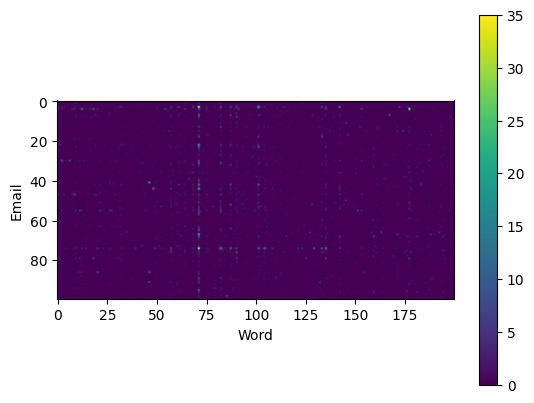

In [10]:
plt.imshow(X_train_bow.toarray()[:100,:200])
plt.xlabel("Word")
plt.ylabel("Email")
plt.colorbar()

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr_bow = LogisticRegression(max_iter=len(y_train))
lr_bow.fit(X_train_bow, y_train)

LogisticRegression(max_iter=66758)

In [12]:
y_pred_train_bow = lr_bow.predict(X_train_bow)
print(f"Accuracy with BoW: {accuracy_score(y_train, y_pred_train_bow)}")

y_pred_test_bow = lr_bow.predict(X_test_bow)
print(f"Accuracy with BoW: {accuracy_score(y_test, y_pred_test_bow)}")

Accuracy with BoW: 0.9762874861439828
Accuracy with BoW: 0.9714200119832235


# Word2Vec

In [13]:
# use gensim to load pre-trained Word2Vec model
from gensim.models import Word2Vec
import gensim.downloader as api
wv = api.load("word2vec-google-news-300")

(300,)


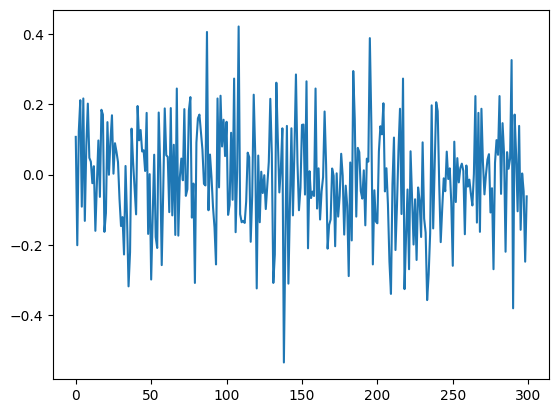

In [14]:
# get embedding of a word
print(wv["computer"].shape)
plt.plot(wv["computer"])

In [15]:
# show that man - woman = king - queen
# queen = king + woman - man
w_1, w_2, w_3 = 'man', 'woman', 'king'
# similarily, apple - banana = red - ?
# w_1, w_2, w_3 = 'apple', 'banana', 'red'

man, woman, king = wv[w_1], wv[w_2], wv[w_3]
tmp = king + woman - man

# find the most similar word to tmp
wv.most_similar(positive=[tmp])

# Try other calculations by yourself!

[('king', 0.8449392318725586),
 ('queen', 0.7300516366958618),
 ('monarch', 0.6454660296440125),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676948547363),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613663792610168),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

# Given one word, find the most similar email

In [16]:
N = 5000 # number of emails to use
import textwrap

# get embeddings of all emails
import re
X_w2v = np.zeros((N, wv.vector_size))
for i in tqdm.tqdm(range(N)):
    email = X[i]
    # convert to lowercase
    email = email.lower()
    # use regex to split the email into words and remove non-alphabetic characters and "_" character
    words = re.findall(r"[a-zA-Z]+", email)
    for word in words:
        if word in wv:
            X_w2v[i] += wv[word]

100%|██████████| 5000/5000 [00:01<00:00, 2608.78it/s]


In [17]:
# normalize X_w2v
X_w2v_normalized = X_w2v / np.linalg.norm(X_w2v, axis=1).reshape(-1, 1)
# fill nan with 0
X_w2v_normalized = np.nan_to_num(X_w2v_normalized)

/var/folders/0n/npvwrk1x7dzd99r7pct35_1r0000gn/T/ipykernel_15116/4196818710.py:2: RuntimeWarning: invalid value encountered in divide
  X_w2v_normalized = X_w2v / np.linalg.norm(X_w2v, axis=1).reshape(-1, 1)


In [18]:
# use BoW to find the most similar email
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(X[:N]).toarray()
X_bow_normalized = X_bow / np.linalg.norm(X_bow, axis=1).reshape(-1, 1)
X_bow_normalized = np.nan_to_num(X_bow_normalized)

In [19]:
# given one topic, find the most similar email
topic = "romantic"
topic_vec = wv[topic]
topic_vec_normalized = topic_vec / np.linalg.norm(topic_vec)
similarity = np.dot(X_w2v_normalized, topic_vec_normalized)
most_similar_email = X[np.argmax(similarity)]
print("Found by Word2Vec:")
print(textwrap.fill(most_similar_email, 100))
print("Number of times the topic word appears in the email:", most_similar_email.lower().count(topic))


# given one topic, find the most similar email
topic_vec = count_vectorizer.transform([topic]).toarray()
topic_vec_normalized = topic_vec / np.linalg.norm(topic_vec)
similarity = np.dot(X_bow_normalized, topic_vec_normalized.T).flatten()
most_similar_email = X[np.argmax(similarity)]
print("\nFound by BoW:")
print(textwrap.fill(most_similar_email, 100))
print("Number of times the topic word appears in the email:", most_similar_email.lower().count(topic))

Found by Word2Vec:
town enough dreams true fruity sweet lands entered regulated law thus celibacy polygamy concern
unmarried
Number of times the topic word appears in the email: 0

Found by BoW:
hi there stranger ! well i haven ' t spoken to you or heard from you in a few days and i ' m just
checkin ' to see that my lil ' buddy in portland isn ' t working himself too hard . as you know i
tried to call you tonight but then had to leave for a workout and a scrimmage soccer game . i am so
sore ! it ' s out of control ! ok so down to the real reason i ' m writing . brendan and i had a
great time at happy hour . we talked a little about you but mostly about life in general . he had
mentioned that he had e - mailed me so i rushed home to check it . basically he said all good things
but there was one thing that struck me as odd . i guess because he also brought the same point up at
the restraunt . he had written that although you thought i was cool and whatever you had commented
on how " stra